# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined. You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criteria to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects of the different combinations of feature sets and model selection criteria.  

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb

asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98, 1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [2]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head() # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [3]:
from asl_utils import test_features_tryit
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx  grnd-lx  
video frame                                      
98    0          113      119        9      -12  
      1          113      119        9      -12  
      2          113      119        9      -12  
      3          113      119        9      -12  
      4          113      119        9      -12

In [4]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['CORN1', 'CAR', 'FRIEND', 'MARY', 'PREFER', 'NOT', 'CORN', 'BROCCOLI', 'BREAK-DOWN', 'GO2', 'FRANK', 'COAT', 'HAVE', 'HOUSE', 'WHAT', 'WOMAN', 'BOY', 'BUY', 'WHO', 'WONT', 'GIRL', 'STOLEN', 'READ', 'TOY', 'VEGETABLE', 'FUTURE', 'BILL', 'TELL', 'LEAVE', 'JANA', 'PARTY', 'TOY1', 'BORROW', 'OLD', 'FINISH', 'NEW-YORK', 'JOHN', 'WANT', 'SELL', 'LIVE', 'WRITE', 'IX-1P', 'THINK', 'APPLE', 'CHICAGO', 'MOVIE', 'GIVE3', 'SELF', 'NEW', 'ANN', 'HOMEWORK', 'POSS', 'LAST-WEEK', 'GROUP', 'LOVE', 'SEARCH-FOR', 'STUDENT', 'SAY-1P', 'SUE', 'MAN', 'DECIDE', 'CHOCOLATE', 'CHINA', 'MANY', 'IX', 'LEG', 'EAT', 'SHOOT', 'VISIT', 'TEACHER', 'SEE', 'PAST', 'SAY', 'CAN', 'FRED', 'LIKE', 'PEOPLE', 'CANDY', 'BLUE', 'TOMORROW', 'VIDEOTAPE', 'BUY1', 'BOX', 'BROTHER', 'BOOK', 'FISH', 'GO', 'HIT', 'SOMETHING-ONE', 'NAME', 'FIND', 'CHICKEN', 'KNOW', 'MOTHER', 'FUTURE1', 'POTATO', 'PUTASIDE', 'GIVE2', 'GIVE', 'WILL', 'GIVE1', 'BUT', 'GO1', 'NEXT-WEEK', 'BLAME', 'YESTERDAY', 'THROW', 'SHOULD', 'ALL', 'AR

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  In addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences (the X portion) and the second is a list of the sequence lengths (the Lengths portion).

In [23]:
training.get_word_Xlengths('CANDY')

(array([[-14,  61,  53, 180],
        [-18,  60,  49, 179],
        [-16,  54,  49, 179],
        [-13,  51,  48, 179],
        [-16,  52,  48, 179],
        [-19,  51,  45, 178],
        [-14,  50,  45, 178],
        [-14,  50,  45, 178],
        [-14,  50,  45, 178],
        [-14,  50,  45, 178],
        [-16,  50,  43, 178],
        [ -9,  59,  43, 178]], dtype=int64), [12])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [5]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-ly,grnd-rx,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,157.036848,-19.567406,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,104.026144,-11.637255,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,118.505134,-13.452679,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [6]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx  grnd-lx  left-x-mean  
video frame                                                   
98    0          113      119        9      -12   164.661438  
      1          113      119        9      -12   164.661438  
      2          113      119        9      -12   164.661438  
      3          113      119        9      -12   164.661438  
      4          113      119        9      -12   164.661438

##### Try it!

In [7]:
from asl_utils import test_std_tryit
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-ly,grnd-rx,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,36.572749,20.269032,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,27.117393,16.764706,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,29.320655,16.191324,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity moves to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [8]:
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
positions = ['right-x', 'right-y', 'left-x', 'left-y']
speakers = asl.df.speaker.unique()

for pos, f_norm in zip(positions, features_norm):
    for speaker in speakers:
        speaker_mean = df_means.loc[speaker, pos]
        speaker_std = df_std.loc[speaker, pos]
        asl.df.ix[asl.df.speaker == speaker, f_norm] = (asl.df.ix[asl.df.speaker == speaker,
                                                                                    pos] - speaker_mean) / speaker_std

In [9]:
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx'] ** 2 + asl.df['grnd-ry'] ** 2)
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx'] ** 2 + asl.df['grnd-ly'] ** 2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [10]:
asl.df['delta-rx'] = asl.df['grnd-rx'].diff(1).fillna(0)
asl.df['delta-lx'] = asl.df['grnd-lx'].diff(1).fillna(0)
asl.df['delta-ry'] = asl.df['grnd-ry'].diff(1).fillna(0)
asl.df['delta-ly'] = asl.df['grnd-ly'].diff(1).fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [11]:
# defining a list of custom features - normalized polar coordinates
features_polar_norm = ['polar_norm-rx', 'polar_norm-ry', 'polar_norm-lx','polar_norm-ly']
positions_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
speakers = asl.df.speaker.unique()

for pos, f_polar_norm in zip(positions_polar, features_polar_norm):
    for speaker in speakers:
        speaker_mean = asl.df.groupby('speaker').mean().loc[speaker, pos]
        speaker_std = asl.df.groupby('speaker').std().loc[speaker, pos]
        asl.df.ix[asl.df.speaker == speaker, f_polar_norm] = (asl.df.ix[asl.df.speaker == speaker,
                                                                                           pos] - speaker_mean) / speaker_std

In [12]:
# adding diff-2 deltas to the custom feature set
asl.df['delta-rx-2'] = asl.df['grnd-rx'].diff(2).fillna(0)
asl.df['delta-lx-2'] = asl.df['grnd-lx'].diff(2).fillna(0)
asl.df['delta-ry-2'] = asl.df['grnd-ry'].diff(2).fillna(0)
asl.df['delta-ly-2'] = asl.df['grnd-ly'].diff(2).fillna(0)

features_delta_two = ['delta-rx-2', 'delta-ry-2', 'delta-lx-2', 'delta-ly-2']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I actually got back to this section after I've tested all my model selectors and found out the polar coordinates outperform other features. Therefore, I decided to normalize the polar coordinates to see if they improve the results any further.

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [14]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [13]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [15]:
my_testword = 'CANDY'
model, logL = train_a_word(my_testword, 4, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CANDY is 4
hidden state #0
mean =  [-0.34906693 -0.71318791  0.18158376  0.55935587]
variance =  [ 0.01234152  0.00175265  0.0016562   0.0016562 ]

hidden state #1
mean =  [-0.48295626 -0.69330503  0.18158376  0.55935587]
variance =  [ 0.02143159  0.00450349  0.00358434  0.00358434]

hidden state #2
mean =  [ 0.0788456  -0.55422957  0.18158376  0.55935587]
variance =  [ 0.01089825  0.01016956  0.00999923  0.00999923]

hidden state #3
mean =  [-0.70039068 -0.56524579  0.18158376  0.55935587]
variance =  [ 0.00584099  0.00582316  0.00460387  0.00460387]

logL = 79.863869971563


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [14]:
%matplotlib inline

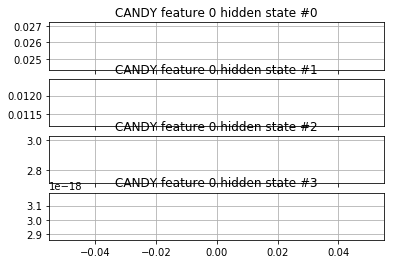

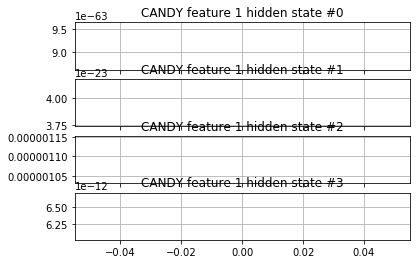

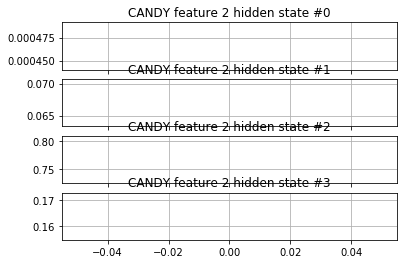

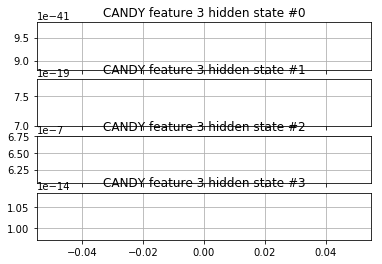

In [22]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follows:

In [15]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
word = 'BOY' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for BOY is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold is scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [16]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the Xlengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criteria
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [17]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [32]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                       min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer() - start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.0362270950099628 seconds
Training complete for BOOK with 2 states with time 2.1572403745594784 seconds
Training complete for VEGETABLE with 14 states with time 1.4490495782001744 seconds
Training complete for FUTURE with 3 states with time 2.322645634379114 seconds
Training complete for JOHN with 7 states with time 15.076249299444498 seconds


In [28]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer() - start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.40500293111017527 seconds
Training complete for BOOK with 5 states with time 2.1645661490820203 seconds
Training complete for VEGETABLE with 5 states with time 0.878652498376141 seconds
Training complete for FUTURE with 7 states with time 2.543138869716131 seconds
Training complete for JOHN with 15 states with time 20.72149567933502 seconds


In [14]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer() - start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 2.7724689900137824 seconds
Training complete for BOOK with 15 states with time 4.4905326708743685 seconds
Training complete for VEGETABLE with 8 states with time 3.4092513736660566 seconds
Training complete for FUTURE with 15 states with time 4.882772940989803 seconds
Training complete for JOHN with 15 states with time 22.682577029965763 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

The first model selector, **SelectorCV**, uses cross-validation to assess the fit models. On each iteration, only "unseen" data is used for evaluation, which consequently yields a more objective (unbiased) view of how our model will perform on new data. Another advantage of this approach is that we average over several scores - that makes for more accurate performance assessment. However, this precision comes with a price - as the number of folds grows, cross-validation becomes increasingly more computationally expensive.

The second selector, **SelectorBIC**, makes model selection a score minimization problem. It can score a model in one pass, which means it runs faster overall. SelectorBIC penalizes models for excessive complexity (having too many parameters), so it's more likely to pick a simple model as the best one. But simple doesn't always equal the best, so the precision of the chosen model may end up being lower as compared with other selector that favor more complex models.

The final model selector, **SelectorDIC**, favors models with high discriminative power, that is models that are more likely to have generated a given word and, at the same time, less likely to have generated other words in the set. To calculate these likelihoods, the selector needs to iterate over the whole word list on each pass, which renders it inefficient for large datasets. It just so happens that more discriminant models tend to have more parameters than those chosen by SelectorBIC, so, given this observation and SelectorDIC's running time, this approach increases overall complexity of the problem at hand. However, in its defense, the DIC [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) to outperform the BIC at the expense of model simplicity.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for your experimentation and final submission cells.



In [15]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, n_constant=3).select()
        model_dict[word] = model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [16]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [40]:
from my_recognizer import recognize
from asl_utils import show_errors

In [24]:
features = features_polar # change as needed
model_selector = SelectorCV # change as needed

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *WHO *VIDEOTAPE HOMEWORK                                      JOHN WRITE HOMEWORK
   67: JOHN FUTURE NOT BUY HOUSE                                     JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE *IX *WHAT                                          JOHN CAN GO CAN
  201: JOHN *FUTURE *WOMAN *LOVE BUY HOUSE                           JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *WHO *MARY MARY                                           JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *HAVE *HAVE *POSS                               SUE BUY IX CAR BLUE
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN *NEW YESTERDAY *TEACHER BOOK              

In [25]:
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
  201: JOHN *MAN *MAN *LIKE BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *CAR CAR *GO                                    SUE BUY IX CAR BLUE
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [20]:
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
  201: JOHN *GIVE *WOMAN *JOHN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *GO *VISIT                                            JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

**Question 3:** Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER? For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

As it turns out, the polar coordinates work very well with all the model selectors, so I provided three code cells to prove it. Above are three combinations that yielded the best results in my experiments. As can be seen, each model resulted in WER < 55%, with the best combination (SelectorCV + features_polar) giving 53.9%.

Speaking about the "winning" model, each of its two components has made its own contribution to the final result. SelectorCV gives more accurate assessments, since it averages over several scores obtained on "unseen" data. The polar coordinates work well by moving the discontinuity to above the speaker's head, which is an area not generally used when signing - this reduces the chance of potential misinterpretation of several otherwise confliclting hand gestures.

To further decrease WER, there are several things to try:

1. Increase the number of folds in SelectorCV - generally, averaging over more scores improves accuracy (at the expense of growing computational expensiveness).
2. Engineer and use other features (as an example, convolutional neural networks might come in handy when extracting features from videos/images). This approach might prove quire performant, but requires at least general knowledge of how neural networks work and a fast GPU for experimenting with different NN architectures.
3. The most obvious approach that almost always helps is to collect more training data. However, gathering it manually may be very time-consuming in the absence of other publicly available datasets.
4. As an extension of the second idea, it's possible to add n-grams to the mixture (as suggested below, in part 4).

In [30]:
# combining all the features actually gives you the best result!
features = features_polar + features_polar_norm + features_norm + features_ground + features_delta + features_delta_two
model_selector = SelectorCV # change as needed

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.4157303370786517
Total correct: 104 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE NOT BUY HOUSE                                     JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE *HAVE *HAVE                                      JOHN CAN GO CAN
  201: JOHN *GIVE1 *WOMAN *LIKE BUY HOUSE                            JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *WHO *MARY MARY                                           JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *HAVE CAR *JOHN                                 SUE BUY IX CAR BLUE
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                  